In [1]:
%pylab inline
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq

fontsize = 20 # for plots

Populating the interactive namespace from numpy and matplotlib


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))

    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,200,2*m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u = u_full[:,-m:]

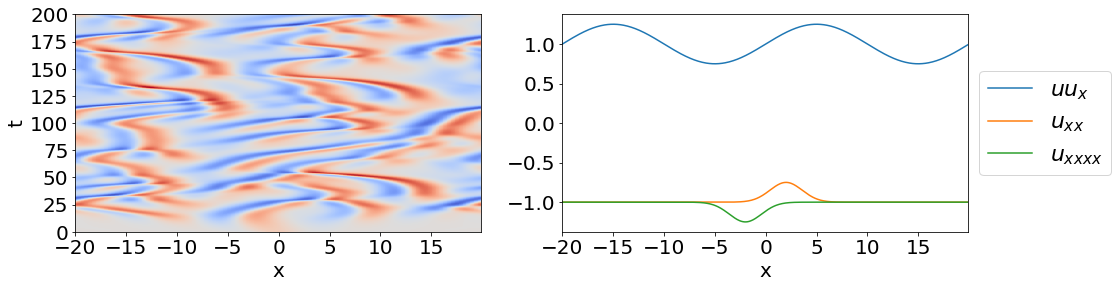

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'Fourier')

/home/samuel/Dropbox (uwamath)/PDE_SINDy/Parametric_PDE_FIND/parametric-discovery/parametric_pde_find.py:305: ComplexWarning: Casting complex values to real discards the imaginary part
  elif space_diff == 'Fourier': ux[:,i] = np.fft.ifft(ik**d*np.fft.fft(u[:,i]))


In [6]:
xi_true = np.zeros((len(rhs_des),m))
i_uu_x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'uu_{x}'][0]
i_u_xx = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xx}'][0]
i_u_4x = [i for i in range(len(rhs_des)) if rhs_des[i] == 'u_{xxxx}'][0]
xi_true[i_uu_x,:] = uu_x_true
xi_true[i_u_xx,:] = u_xx_true
xi_true[i_u_4x,:] = u_4x_true

In [7]:
Theta_grouped = [real(Theta[n*np.arange(m)+j,:]) for j in range(n)]
Ut_grouped = [real(Ut[n*np.arange(m)+j]) for j in range(n)]

MSE:  7.16342970697e-06


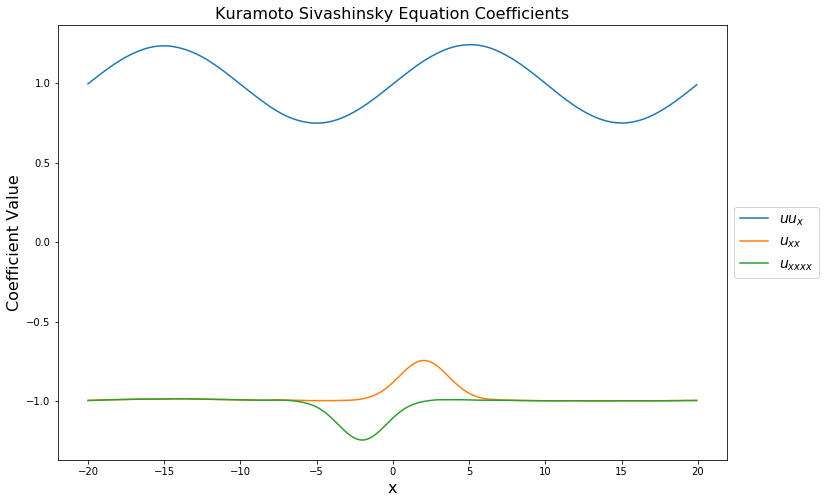

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x, xi[j,:], label = '$'+rhs_des[j]+'$')
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_sgtr = Norm(xi-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_sgtr)

(array([-3018050., -3018025., -3018000., -3017975., -3017950., -3017925.,
        -3017900., -3017875., -3017850., -3017825.]),
 <a list of 10 Text yticklabel objects>)

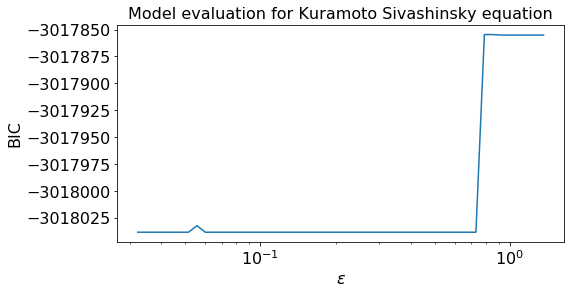

In [9]:
figure(figsize = (8,4))

semilogx(Tol,Losses)

title('Model evaluation for Kuramoto Sivashinsky equation', fontsize = 16)
ylabel('BIC', fontsize = 16)
xlabel(r'$\epsilon$', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)

MSE:  8.13934440899e-06


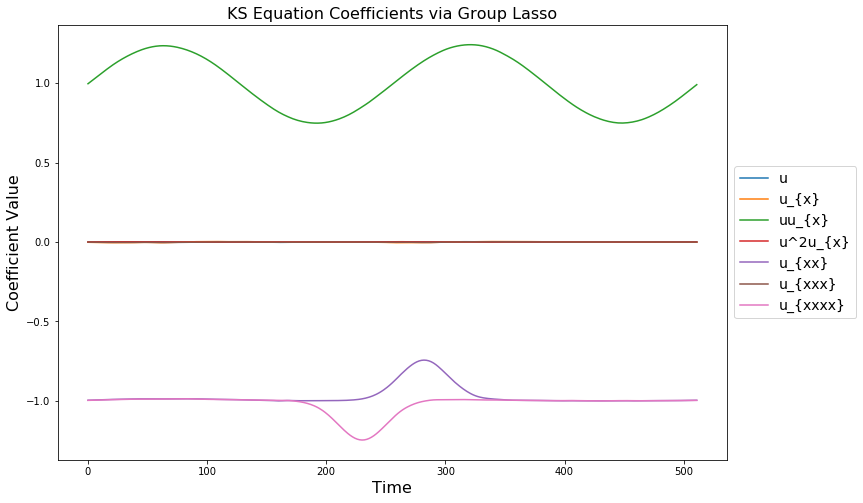

In [10]:
D = Theta_grouped[0].shape[1]
groups = [[j+D*i for i in range(n)] for j in range(D)]
Xi_lasso,Lam_lasso,Losses_lasso,History_lasso = TrainGroupLasso(Theta_grouped, Ut_grouped, groups)
xi_lasso = Xi_lasso[np.argmin(Losses_lasso)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso.shape[0]): 
    if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
        plot(xi_lasso[j,:], label = rhs_des[j])

title('KS Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_clean_lasso = Norm(xi_lasso-xi_true)**2/(m*len(rhs_des))
print('MSE: ', mse_clean_lasso)

In [11]:
un = u + 0.0001*std(u)*np.random.randn(n,m)

In [12]:
# Build linear systems
wx = 10
wt = 10

deg_x = 6
deg_t = 4

Utn, Thetan, rhs_des = build_linear_system(un, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = deg_x, deg_t = deg_t, 
                                       width_x = wx, width_t = wt)
n2 = n - 2*wx
m2 = m - 2*wt

In [13]:
# Group by location
Thetan_grouped = [real(Thetan[n2*np.arange(m2)+j,:]) for j in range(n2)]
Utn_grouped = [real(Utn[n2*np.arange(m2)+j]) for j in range(n2)]

MSE:  0.00638016096758


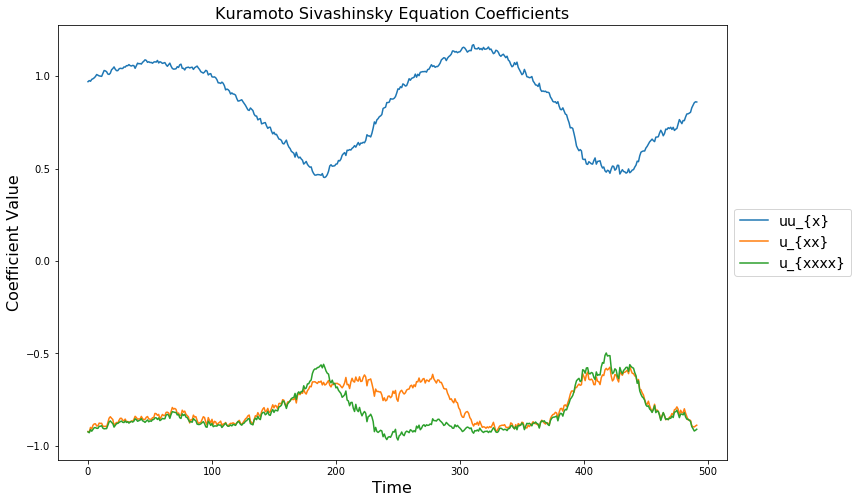

In [14]:
Xi_n,Tol_n,Losses_n = TrainSGTRidge(Thetan_grouped, Utn_grouped)
xi_n = Xi_n[np.argmin(Losses_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(xi_n[j,:], label = rhs_des[j])

title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_sgtr = Norm(xi_n-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_sgtr)

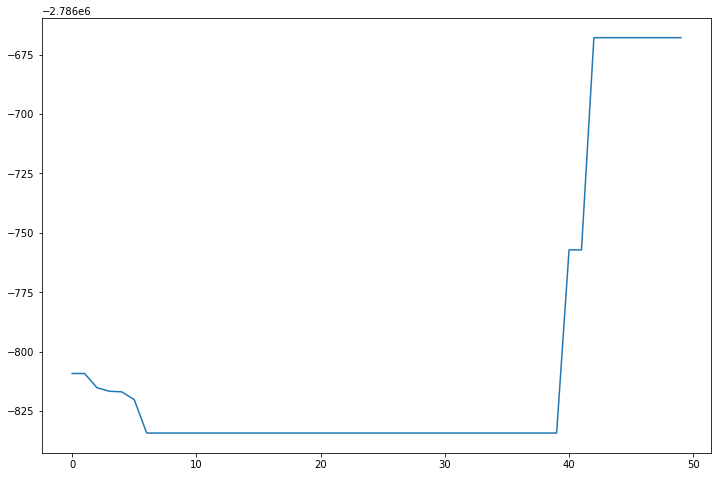

In [15]:
plot(Losses_n)

MSE:  0.00984199496743


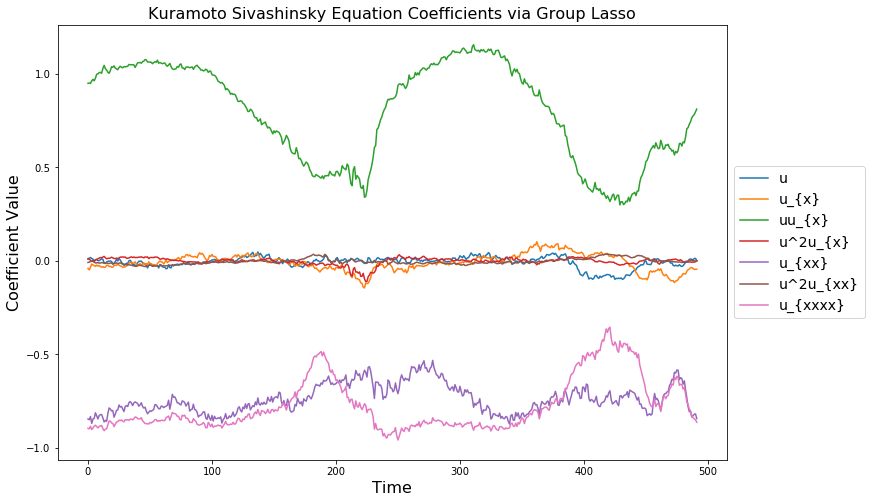

In [16]:
D = Thetan_grouped[0].shape[1]
groups = [[j+D*i for i in range(n2)] for j in range(D)]
Xi_lasso_n,Lam_lasso_n,Losses_lasso_n,History_lasso_n = TrainGroupLasso(Thetan_grouped, Utn_grouped, groups)
xi_lasso_n = Xi_lasso_n[np.argmin(Losses_lasso_n)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi_lasso_n.shape[0]): 
    if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        plot(xi_lasso_n[j,:], label = rhs_des[j])

title('Kuramoto Sivashinsky Equation Coefficients via Group Lasso', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

mse_noise_lasso = Norm(xi_lasso_n-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
print('MSE: ', mse_noise_lasso)

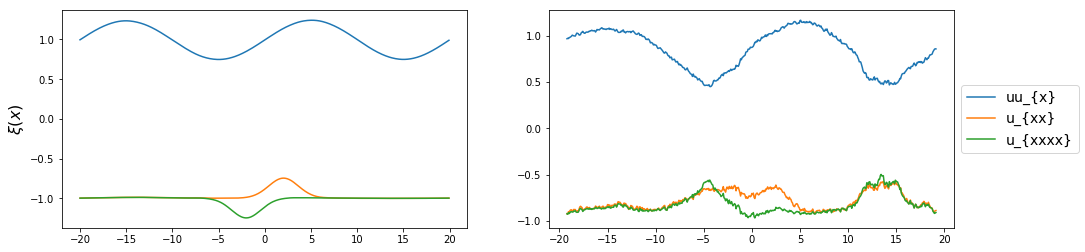

In [17]:
figure(figsize = (16,4))
label_fs = 16

subplot(1,2,1)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(x,xi[j,:], label = rhs_des[j])

ylabel(r'$\xi(x)$', fontsize = 16)

subplot(1,2,2)
for j in range(xi_n.shape[0]): 
    if np.linalg.norm(xi_n[j,:]) > 10**-10:
        plot(x[wx:-wx],xi_n[j,:], label = rhs_des[j])

legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)

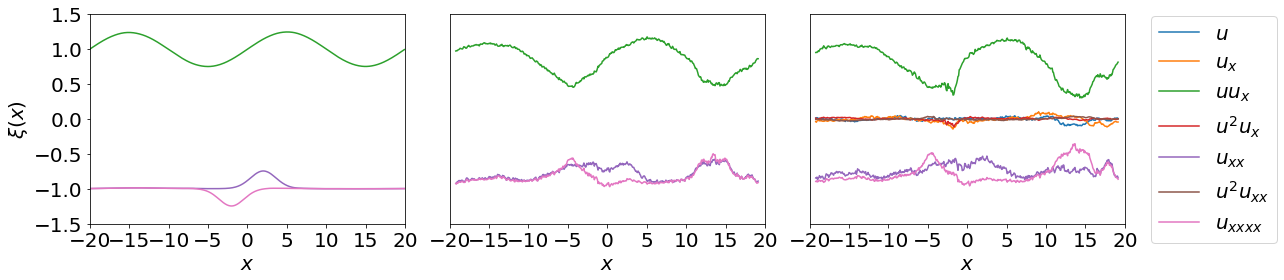

In [18]:
figure(figsize = (16,4))

for j in range(xi.shape[0]): 
    
    if np.linalg.norm(xi[j,:]) > 10**-10 or \
       np.linalg.norm(xi_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        
        subplot(1,3,1)
        if np.linalg.norm(xi[j,:]) > 10**-10:
            plot(x,xi[j,:], label = rhs_des[j])
        else: plot([-100,-99], [0,0])
            
        subplot(1,3,2)
        if np.linalg.norm(xi_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_n[j,:], label = rhs_des[j])
        else: plot([-100,-99], [0,0])
        
        subplot(1,3,3)
        if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_lasso_n[j,:], label = '$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0], label = '$'+rhs_des[j]+'$')

subplot(1,3,1); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks(fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize)
subplot(1,3,2); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks([]); xlabel(r'$x$', fontsize = fontsize)
subplot(1,3,3); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks([]); xlabel(r'$x$', fontsize = fontsize)

subplot(1,3,1); ylabel(r'$\xi(x)$', fontsize = fontsize)
subplot(1,3,3); legend(loc='center left', bbox_to_anchor=(1.05, 0.45), fontsize = fontsize)

tight_layout()

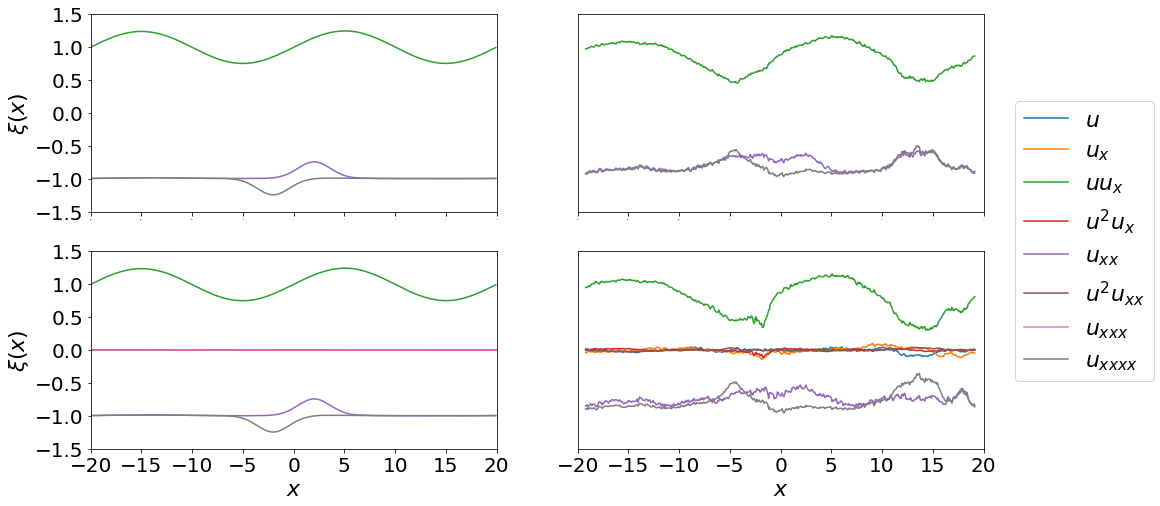

In [19]:
figure(figsize = (16,8))

for j in range(xi.shape[0]): 
    
    if np.linalg.norm(xi[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso[j,:]) > 10**-10 or \
       np.linalg.norm(xi_n[j,:]) > 10**-10 or \
       np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
        
        subplot(2,2,1)
        if np.linalg.norm(xi[j,:]) > 10**-10:
            plot(x,xi[j,:], label = rhs_des[j])
        else: plot([-100,-99], [0,0])
            
        subplot(2,2,2)
        if np.linalg.norm(xi_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_n[j,:], label = rhs_des[j])
        else: plot([-100,-99], [0,0])
            
        subplot(2,2,3)
        if np.linalg.norm(xi_lasso[j,:]) > 10**-10:
            plot(x,xi_lasso[j,:], label = '$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0], label = '$'+rhs_des[j]+'$')
        
        subplot(2,2,4)
        if np.linalg.norm(xi_lasso_n[j,:]) > 10**-10:
            plot(x[wx:-wx],xi_lasso_n[j,:], label = '$'+rhs_des[j]+'$')
        else: plot([-100,-99], [0,0], label = '$'+rhs_des[j]+'$')

subplot(2,2,1); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = 0); yticks(fontsize = fontsize)
subplot(2,2,2); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = 0); yticks([])
subplot(2,2,3); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks(fontsize = fontsize); xlabel(r'$x$', fontsize = fontsize+2)
subplot(2,2,4); xlim([-L,L]); ylim([-1.5,1.5]); xticks(fontsize = fontsize); yticks([]); xlabel(r'$x$', fontsize = fontsize+2)

subplot(2,2,1); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(2,2,3); ylabel(r'$\xi(x)$', fontsize = fontsize+2)
subplot(2,2,4); legend(loc='center left', bbox_to_anchor=(1.05, 1.05), fontsize = fontsize+2)

# tight_layout()